In [ ]:
#기본 웹캠 코드
import cv2

def main():
    # 웹캠 연결
    cap = cv2.VideoCapture(0)  # 0은 기본 웹캠을 의미합니다. 여러분이 다른 카메라를 사용하고 싶다면, 1, 2 등의 값을 넣어보세요.
    
    # 웹캠이 제대로 열렸는지 확인
    if not cap.isOpened():
        print("웹캠을 열 수 없습니다.")
        return
    
    # 창 생성 및 설정
    cv2.namedWindow('Webcam', cv2.WINDOW_NORMAL)  # 창 이름과 창 모드 설정
    
    while True:
        # 웹캠에서 프레임 읽기
        ret, frame = cap.read()
        
        if not ret:
            print("프레임을 읽을 수 없습니다.")
            break
        
        # 프레임을 창에 표시
        cv2.imshow('Webcam', frame)
        
        # 'q' 키를 누르면 종료
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # 작업 완료 후 해제
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
core = ov.Core()
model_face = core.read_model(model='models/face-detection-adas-0001.xml')
compiled_model_face = core.compile_model(model = model_face, device_name="CPU")
input_layer_face = compiled_model_face.input(0)
output_layer_face = compiled_model_face.output(0)

model_emo = core.read_model(model='models/emotions-recognition-retail-0003.xml')
compiled_model_emo = core.compile_model(model = model_emo, device_name="GPU")
input_layer_emo = compiled_model_emo.input(0)
output_layer_emo = compiled_model_emo.output(0)

model_ag = core.read_model(model='models/age-gender-recognition-retail-0013.xml')
compiled_model_ag = core.compile_model(model = model_ag, device_name="GPU")
input_layer_ag = compiled_model_ag.input(0)
output_layer_ag = compiled_model_ag.output(0)

def draw_ag_emo(face_boxes, image):
    show_image = image.copy()
    EMOTION_NAMES = ['nomal', 'happy', 'sad', 'suprise', 'anger']
    for i in range(len(face_boxes)):
        xmin, ymin, xmax, ymax = face_boxes[i]
        if xmin < 0 or ymin < 0 or xmax > image.shape[1] or ymax > image.shape[0]:
            continue
        face = image[ymin:ymax, xmin:xmax]
        input_image_emo = preprocess(face, input_layer_emo)
        results_emo = compiled_model_emo([input_image_emo])[output_layer_emo]
        results_emo = results_emo.squeeze()
        index = np.argmax(results_emo)
        input_image_ag = preprocess(face, input_layer_ag)
        results_ag = compiled_model_ag([input_image_ag])
        age, gender = results_ag[1], results_ag[0]
        age = np.squeeze(age)
        age = int(age*100)
        gender = np.squeeze(gender)
        if (gender[0]>=0.85):
            gender = "female"
            color = (0, 0, 255)
        elif (gender[1]>=0.8):
            gender = "male"
            color = (255, 0, 0)
        else:
            gender = "unknown"
            color = (0, 0, 0)
        text = gender + ' ' + str(age) + ' ' + EMOTION_NAMES[index]
        cv2.rectangle(show_image, (xmin,ymin), (xmax,ymax), color, int(fontScale*3))
        cv2.putText(show_image, text, (xmin, ymin-30), cv2.FONT_HERSHEY_SIMPLEX, fontScale, color, int(fontScale*3))
    return show_image
def preprocess(image, input_layer_face):
    N, input_channels, input_height, input_width = input_layer_face.shape
    resized_image = cv2.resize(image, (input_width, input_height))
    transposed_image = resized_image.transpose(2, 0, 1)
    input_image = np.expand_dims(transposed_image, 0)
    return input_image
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()
    scores = results[:,2]
    boxes = results[:,-4:]
    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]
    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes*np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)
    return face_boxes, scores

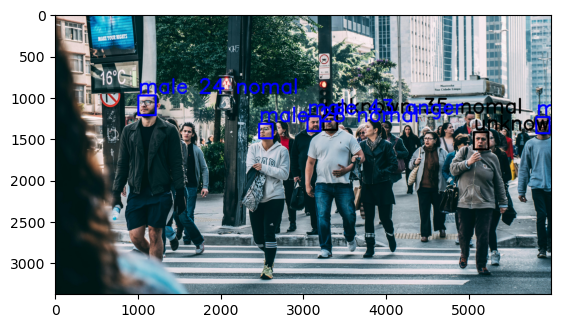

In [12]:
image = cv2.imread("persons.jpg")
fontScale = image.shape[1]/750 
input_image = preprocess(image, input_layer_face)
results = compiled_model_face([input_image])[output_layer_face]
confidence_threshold = .15
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
show_image = draw_ag_emo(face_boxes, image)
plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

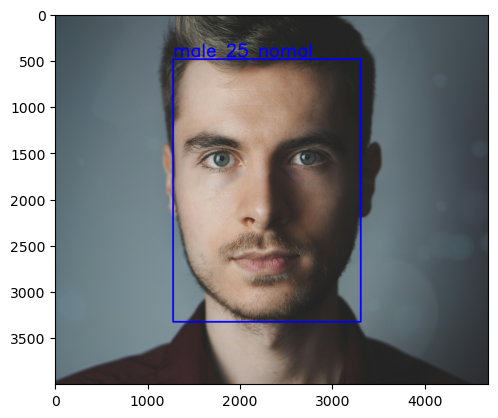

In [10]:
image = cv2.imread("person.jpg")
fontScale = image.shape[1]/750 
input_image = preprocess(image, input_layer_face)
results = compiled_model_face([input_image])[output_layer_face]
confidence_threshold = .15
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
show_image = draw_ag_emo(face_boxes, image)
plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

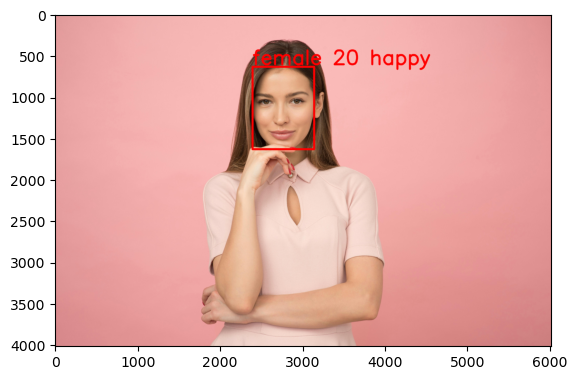

In [11]:
image = cv2.imread("woman.jpg")
fontScale = image.shape[1]/750 
input_image = preprocess(image, input_layer_face)
results = compiled_model_face([input_image])[output_layer_face]
confidence_threshold = .15
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
show_image = draw_ag_emo(face_boxes, image)
plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

In [8]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 100000)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 100000)
while True:
    ret, image = cap.read()
    if not ret:
        break
    #보기 편하라고 플립
    image = cv2.flip(image, 1)
    fontScale = image.shape[1]/750 
    input_image = preprocess(image, input_layer_face)
    results = compiled_model_face([input_image])[output_layer_face]
    confidence_threshold = .60
    face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
    show_image = draw_ag_emo(face_boxes, image)
    cv2.imshow('Age and gender and emotions', show_image)
    key = cv2.waitKey(1)
    if key == 27:
        break
cap.release()
cv2.destroyAllWindows()